In [2]:
import numpy as np
import pandas as pd

from Replayers import ABTestReplayer, EpsilonGreedyReplayer, ThompsonSamplingReplayer

In [9]:
movie_df = pd.read_csv('raw/u.item', sep='|', header=None, encoding='latin1', index_col=False,
                   names=['movie_id',
                          'movie_title',
                          'release_date',
                          'video_release_date',
                          'imdb_url',
                          'unknown',
                          'action',
                          'adventure',
                          'animation',
                          'children',
                          'comedy',
                          'crime',
                          'documentary',
                          'drama',
                          'fantasy',
                          'film_noir',
                          'horror',
                          'musical',
                          'mystery'
                          'romance',
                          'sci_fi',
                          'thriller',
                          'war',
                          'western'])

movie_df.movie_id -= 1 # make this column zero-indexed

In [10]:
movie_df.head()

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,children,...,drama,fantasy,film_noir,horror,musical,mysteryromance,sci_fi,thriller,war,western
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [11]:
rating_df = pd.read_csv('raw/u.data', sep='\t', header=None, names=['user_id','movie_id','rating','timestamp'])
rating_df.user_id -= 1 # make this column zero-indexed
rating_df.movie_id -= 1 # make this column zero-indexed

In [12]:
movie_counts = rating_df.groupby('movie_id')['rating'].count().sort_values(ascending=False)
n_movies = 50
top_n_movies = rating_df.query('movie_id in {}'.format((movie_counts[:n_movies].index.values.tolist())))

In [13]:
# add the movie title for ease of access when plotting
# remove the timestamp column because we don't need it
top_n_movies = top_n_movies.merge(movie_df[['movie_id','movie_title']], on='movie_id', how='left') \
                           .drop(columns=['timestamp'])

In [14]:
top_n_movies.head()

,user_id,movie_id,rating,movie_title
0,185,301,3,L.A. Confidential (1997)
1,61,256,2,Men in Black (1997)
2,199,221,5,Star Trek: First Contact (1996)
3,290,117,2,Twister (1996)
4,307,0,4,Toy Story (1995)


In [15]:
# save the output for use in other notebooks
top_n_movies.to_csv('top-n-movies_user-ratings.csv')

## Reading data

In [16]:
rating_df = pd.read_csv('top-n-movies_user-ratings.csv').drop(columns='Unnamed: 0')
rating_df.head()

,user_id,movie_id,rating,movie_title
0,185,301,3,L.A. Confidential (1997)
1,61,256,2,Men in Black (1997)
2,199,221,5,Star Trek: First Contact (1996)
3,290,117,2,Twister (1996)
4,307,0,4,Toy Story (1995)


In [17]:
reward_threshold = rating_df.rating.mean()
rating_df['reward'] = rating_df.eval('rating > @reward_threshold').astype(int)
rating_df.shape

(17841, 5)

## Setting parameters for simulations

In [18]:
n_visits = 20000
n_iterations = 20

reward_history = rating_df
item_col_name = 'movie_id'
visitor_col_name = 'user_id'
reward_col_name = 'reward'

In [19]:
thompson_results = ThompsonSamplingReplayer(n_visits, reward_history,
                                            item_col_name, visitor_col_name, reward_col_name,
                                            n_iterations=n_iterations).replay()

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:06:20<00:00, 208.56s/it]


In [20]:
thompson_results_df = pd.DataFrame(thompson_results)
thompson_results_df.head()

,fraction_relevant,item_id,iteration,reward,total_reward,visit,visitor_id
0,1.00,287,0,1,1,0,302
1,1.00,287,0,1,2,1,514
2,1.00,175,0,1,3,2,369
3,0.75,182,0,0,3,3,888
4,0.80,256,0,1,4,4,929


In [22]:
thompson_results_df.to_csv('thompson_sampling.csv')

In [23]:
thompson_avg_results_df = thompson_results_df.groupby('visit', as_index=False).mean()

In [29]:
thompson_avg_results_df.head()

,visit,fraction_relevant,item_id,iteration,reward,total_reward,visitor_id
0,0,0.750000,167.50,9.5,0.75,0.75,429.35
1,1,0.650000,215.00,9.5,0.55,1.30,552.60
2,2,0.666667,158.75,9.5,0.70,2.00,429.80
3,3,0.650000,176.10,9.5,0.60,2.60,535.05
4,4,0.640000,234.70,9.5,0.60,3.20,400.55


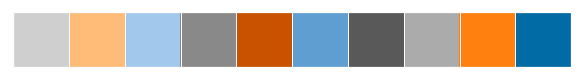

In [26]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=2.5)
# using a color-blind friendly palette with 10 colors
color_blind_palette_10 = ['#cfcfcf', '#ffbc79', '#a2c8ec', '#898989', '#c85200',
                          '#5f9ed1', '#595959', '#ababab', '#ff800e', '#006ba4']

sns.palplot(color_blind_palette_10)

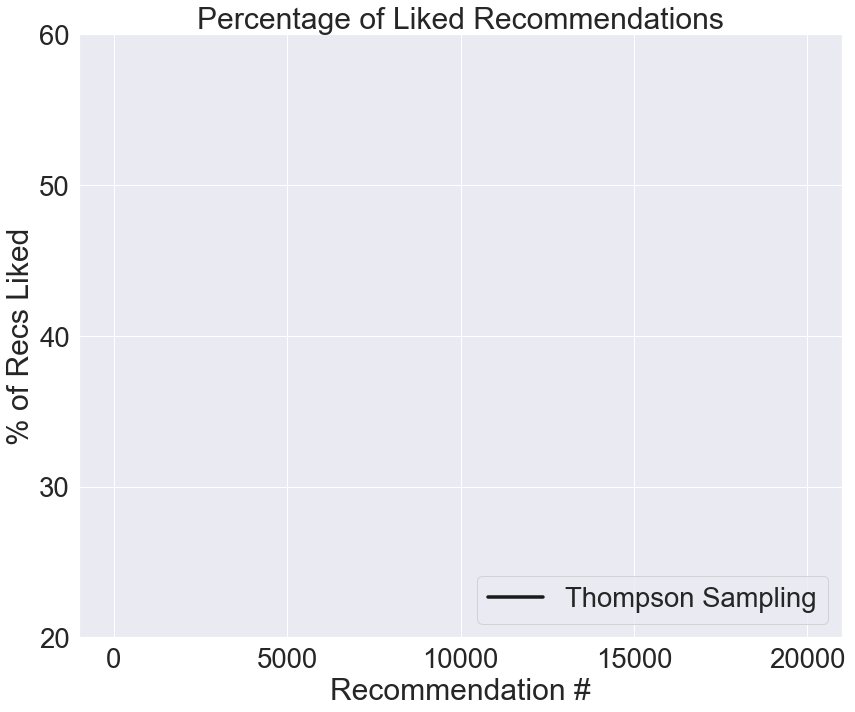

In [32]:
fig, ax = plt.subplots(figsize=(12,10))

ax.plot(thompson_avg_results_df.visit, thompson_avg_results_df.fraction_relevant,color = 'k', linewidth=3.5)

# add a line for the optimal value -- 0.5575 for Star Wars (from exploration noteboook)
#ax.axhline(y=0.5575, color='k', linestyle=':', linewidth=2.5)

ax.set_title('Percentage of Liked Recommendations')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('% of Recs Liked')

ax.set_xticks(range(0,22000,5000))
ax.set_ylim(0.2, 0.6)
ax.set_yticks(np.arange(0.2, 0.7, 0.1))

# rescale the y-axis tick labels to show them as a percentage
ax.set_yticklabels((ax.get_yticks()*100).astype(int))

ax.legend(['Thompson Sampling',
           'Optimal (Star Wars)'
          ],
          loc='lower right'
         )

plt.tight_layout()
plt.show()